# Model Neuronal Network

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.init as init
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

## Data to Tensor

In [2]:
df = pd.read_csv('../Data/preprocessing.csv')
X = df.drop(columns='target')
y = df['target']
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=13, stratify=y
)

In [3]:
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).view(-1,1)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).view(-1,1)

In [4]:
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32)

## Create Neural Network

In [5]:
class ChurnNN(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, activation, dropout_rate):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, hidden_dim)
        self.fc4 = nn.Linear(hidden_dim, output_dim)

        self.activation = activation
        self.dropout = nn.Dropout(dropout_rate)

        for layer in [self.fc1, self.fc2, self.fc3, self.fc4]:
            init.kaiming_uniform_(layer.weight, nonlinearity='relu')
            init.zeros_(layer.bias)

    def forward(self, x):
        x = self.activation(self.fc1(x))
        x = self.dropout(x)
        x = self.activation(self.fc2(x))
        x = self.dropout(x)
        x = self.activation(self.fc3(x))
        x = torch.sigmoid(self.fc4(x))

        return x


In [6]:
model = ChurnNN(input_dim=X.shape[1], hidden_dim=64, output_dim=1, activation=nn.ReLU(), dropout_rate=0.3)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss_fn = nn.BCELoss()

## Train Neural Network

In [7]:
num_epochs = 50

for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        y_pred = model(X_batch)
        loss = loss_fn(y_pred, y_batch)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    
    print(f"Epoch {epoch+1}/{num_epochs} - Loss: {total_loss:.4f}")


Epoch 1/50 - Loss: 35.3526
Epoch 2/50 - Loss: 26.5480
Epoch 3/50 - Loss: 24.4185
Epoch 4/50 - Loss: 24.7175
Epoch 5/50 - Loss: 23.0420
Epoch 6/50 - Loss: 22.7712
Epoch 7/50 - Loss: 21.9203
Epoch 8/50 - Loss: 21.8644
Epoch 9/50 - Loss: 20.9422
Epoch 10/50 - Loss: 20.1526
Epoch 11/50 - Loss: 20.1621
Epoch 12/50 - Loss: 19.6211
Epoch 13/50 - Loss: 19.5215
Epoch 14/50 - Loss: 18.4147
Epoch 15/50 - Loss: 17.9371
Epoch 16/50 - Loss: 19.0535
Epoch 17/50 - Loss: 17.4654
Epoch 18/50 - Loss: 18.2772
Epoch 19/50 - Loss: 17.8425
Epoch 20/50 - Loss: 17.1923
Epoch 21/50 - Loss: 17.5210
Epoch 22/50 - Loss: 16.7837
Epoch 23/50 - Loss: 16.9694
Epoch 24/50 - Loss: 16.3367
Epoch 25/50 - Loss: 16.4057
Epoch 26/50 - Loss: 15.6408
Epoch 27/50 - Loss: 15.4161
Epoch 28/50 - Loss: 15.5972
Epoch 29/50 - Loss: 16.0007
Epoch 30/50 - Loss: 15.8577
Epoch 31/50 - Loss: 15.8338
Epoch 32/50 - Loss: 15.6816
Epoch 33/50 - Loss: 14.6261
Epoch 34/50 - Loss: 15.6509
Epoch 35/50 - Loss: 14.7090
Epoch 36/50 - Loss: 14.7300
E

## Evaluate Neural Network

In [8]:
model.eval()
y_pred_list = []

with torch.no_grad():
    for X_batch, _ in test_loader:
        y_test_pred = model(X_batch)
        y_test_pred = torch.round(y_test_pred)
        y_pred_list.append(y_test_pred)

y_pred = torch.cat(y_pred_list).numpy().flatten()
y_true = y_test.to_numpy()

eval = pd.DataFrame([{
    "Accuracy": accuracy_score(y_true, y_pred),
    "Precision": precision_score(y_true, y_pred),
    "Recall": recall_score(y_true, y_pred),
    "F1 Score": f1_score(y_true, y_pred)
}])

eval.to_csv('../Outputs/Tables/evaluation_model.csv', index=False)

print("Accuracy:", accuracy_score(y_true, y_pred))
print("Precision:", precision_score(y_true, y_pred))
print("Recall:", recall_score(y_true, y_pred))
print("F1 Score:", f1_score(y_true, y_pred))


Accuracy: 0.9543859649122807
Precision: 0.9257425742574258
Recall: 0.9444444444444444
F1 Score: 0.935


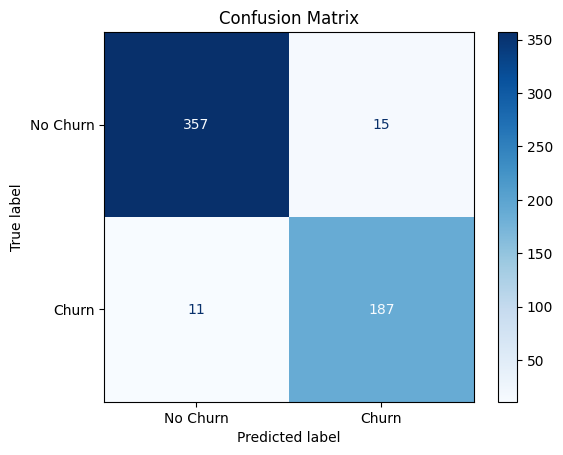

<Figure size 640x480 with 0 Axes>

In [11]:
y_true = y_test.to_numpy()
y_pred = y_pred.astype(int)

cm = confusion_matrix(y_true, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["No Churn", "Churn"])
disp.plot(cmap="Blues")

plt.title("Confusion Matrix")
plt.show()
plt.savefig("../Outputs/Figures/confusion_matrix.png", dpi=300, bbox_inches='tight')

In [10]:
torch.save(model.state_dict(), '../Outputs/Models/churn_model.pth')